In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Mar  4 12:10:56 2020

@author: gracehymas
"""

import numpy as np
import pandas as pd
import tensorflow as tf
import keras.backend as K
from sklearn.preprocessing import scale
from keras.layers import (BatchNormalization, Conv2D, Conv2DTranspose, Dense,
                          Dropout, Flatten, Input, Reshape, UpSampling2D,
                          ZeroPadding2D)
from keras.layers.advanced_activations import LeakyReLU
from keras.models import *
from keras.optimizers import SGD, Adam
from sklearn.preprocessing import StandardScaler
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import scale
from keras.utils import plot_model
from keras.callbacks import History
from keras import metrics
import time
import os
from copy import deepcopy
import tensorflow as tf

import sys
sys.path.append("../dataset-and-plotting")
from nnPlotting import *
from sensitivity import *

def totalSensitivity(A,B,errorA,errorB):
    totalSensitivity = np.sqrt(A**2 + B**2)
    totalError = np.sqrt(((A*errorA)/np.sqrt(A**2 + B**2))**2 + ((B*errorB)/np.sqrt(A**2 + B**2))**2)

    return (totalSensitivity,totalError)

dataStorage = np.zeros((500, 7))


def create_generator():
    
    generator = Sequential()
    
    generator.add(Dense(30, activation="tanh",input_dim=noise_dim))
    generator.add(Dense(2, activation="softmax"))
    
    generator.add(Dense(len(variables), activation='tanh'))
                  
    generator.compile(loss='mean_squared_error', optimizer=optimizer)
    
    return generator


def create_descriminator():
    
    discriminator = Sequential()
    
    discriminator.add(Dense(40, activation="linear", input_dim=len(variables)))
    discriminator.add(Dense(40, activation="tanh"))
    discriminator.add(Dense(40, activation="tanh"))
    
    discriminator.add(Dense(1, activation="sigmoid"))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=optimiserClassifier, metrics=['binary_accuracy'])
    
    return discriminator


mirrored_strategy = tf.distribute.MirroredStrategy()

variables = ['pTB1','pTB2']

np.random.seed(10)

dfEven = pd.read_csv('../dataset-and-plotting/CSV/VHbb_data_2jet_even.csv')
dfOdd = pd.read_csv('../dataset-and-plotting/CSV/VHbb_data_2jet_odd.csv')

df = pd.concat([dfEven,dfOdd])

dfTrain = df.loc[df['category'] == 'VH']
x_train_array = dfTrain[variables].to_numpy()

#scaler = StandardScaler()
#x_train = scaler.fit_transform(x_train_array)
x_train = x_train_array

batch_size = 64
steps_per_epoch = int(len(dfTrain) / batch_size)

noise_dim = 100
epochs = 500

optimizer = SGD(0.01)

optimiserClassifier = SGD(lr=0.001, momentum=0.5, decay=0.00001)

discriminator = create_descriminator()
generator = create_generator()

# Link the two models to create the GAN
gan_input = Input(shape=(noise_dim,))

fake_event = generator(gan_input)

gan_output = discriminator(fake_event)

gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)

dloss = []
gloss = []

for epoch in range(epochs):
    for batch in range(steps_per_epoch):
        
        noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
        fake_x = generator.predict(noise)

        real_x = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
        
        x = np.concatenate((real_x, fake_x))

        # First half of y-values are 0.9 corresponding to real data, not using 1 for label smoothing
        # Second half are 0 corresponding to the fake data we made
        disc_y = np.zeros(2*batch_size)
        disc_y[:batch_size] = 0.9
        
        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(x, disc_y)

        discriminator.trainable = False
        y_gen = np.ones(batch_size)
        g_loss = gan.train_on_batch(noise, y_gen)
        
    dloss.append(d_loss[0])
    gloss.append(g_loss)   
    print(f'Epoch: {epoch} \t Discriminator Loss: {d_loss} \t\t Generator Loss: {g_loss}')

df = pd.DataFrame(np.array([dloss,gloss]).T, columns = ['discriminator', 'generator'])
df.to_csv("ThisIsLossSimpleLong.csv")

discriminator.save('Discriminator.hdf5')
generator.save('Generator.hdf5')

Using TensorFlow backend.


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


../dataset-and-plotting/nnPlotting.py:10: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 0 	 Discriminator Loss: [1.3769336, 0.0] 		 Generator Loss: 0.0938756912946701
Epoch: 1 	 Discriminator Loss: [1.3817214, 0.0] 		 Generator Loss: 0.09310531616210938
Epoch: 2 	 Discriminator Loss: [1.3865819, 0.0] 		 Generator Loss: 0.09223754703998566
Epoch: 3 	 Discriminator Loss: [1.3910187, 0.0] 		 Generator Loss: 0.09135377407073975
Epoch: 4 	 Discriminator Loss: [1.3967855, 0.0] 		 Generator Loss: 0.09026625752449036
Epoch: 5 	 Discriminator Loss: [1.4015301, 0.0] 		 Generator Loss: 0.08929625153541565
Epoch: 6 	 Discriminator Loss: [1.4064267, 0.0] 		 Generator Loss: 0.08833974599838257
Epoch: 7 	 Discriminator Loss: [1.4114841, 0.0] 		 Generator Loss: 0.08739836513996124
Epoch: 8 	 Discriminator Loss: [1.4162548, 0.0] 		 Generator Loss: 0.08649292588233948
Epoch: 9 	 Discriminator Loss: [1.421278, 0.0] 		 Generator Loss: 0.08556117117404938
Epoch: 10 	 Discriminator Loss: [1.4262384, 0.0] 		 Generator Loss: 0.08465002477169037
Epoch: 11 	 Discriminator Loss: [1.4306893, 

Epoch: 94 	 Discriminator Loss: [1.7250681, 0.0] 		 Generator Loss: 0.04524170607328415
Epoch: 95 	 Discriminator Loss: [1.7276285, 0.0] 		 Generator Loss: 0.045004282146692276
Epoch: 96 	 Discriminator Loss: [1.730252, 0.0] 		 Generator Loss: 0.0447690486907959
Epoch: 97 	 Discriminator Loss: [1.7332165, 0.0] 		 Generator Loss: 0.04449097439646721
Epoch: 98 	 Discriminator Loss: [1.735597, 0.0] 		 Generator Loss: 0.04427122324705124
Epoch: 99 	 Discriminator Loss: [1.7382135, 0.0] 		 Generator Loss: 0.044033538550138474
Epoch: 100 	 Discriminator Loss: [1.740912, 0.0] 		 Generator Loss: 0.043790288269519806
Epoch: 101 	 Discriminator Loss: [1.743549, 0.0] 		 Generator Loss: 0.04355274885892868
Epoch: 102 	 Discriminator Loss: [1.7461753, 0.0] 		 Generator Loss: 0.043322883546352386
Epoch: 103 	 Discriminator Loss: [1.7487552, 0.0] 		 Generator Loss: 0.043091025203466415
Epoch: 104 	 Discriminator Loss: [1.7513707, 0.0] 		 Generator Loss: 0.042864199727773666
Epoch: 105 	 Discriminator

Epoch: 187 	 Discriminator Loss: [1.9280922, 0.0] 		 Generator Loss: 0.029851801693439484
Epoch: 188 	 Discriminator Loss: [1.9297957, 0.0] 		 Generator Loss: 0.029747091233730316
Epoch: 189 	 Discriminator Loss: [1.9315484, 0.0] 		 Generator Loss: 0.029642250388860703
Epoch: 190 	 Discriminator Loss: [1.9333154, 0.0] 		 Generator Loss: 0.029535692185163498
Epoch: 191 	 Discriminator Loss: [1.9351673, 0.0] 		 Generator Loss: 0.029423128813505173
Epoch: 192 	 Discriminator Loss: [1.9369245, 0.0] 		 Generator Loss: 0.029317986220121384
Epoch: 193 	 Discriminator Loss: [1.9387162, 0.0] 		 Generator Loss: 0.029211152344942093
Epoch: 194 	 Discriminator Loss: [1.9404733, 0.0] 		 Generator Loss: 0.029106751084327698
Epoch: 195 	 Discriminator Loss: [1.94224, 0.0] 		 Generator Loss: 0.029002144932746887
Epoch: 196 	 Discriminator Loss: [1.9441485, 0.0] 		 Generator Loss: 0.02889210358262062
Epoch: 197 	 Discriminator Loss: [1.9457107, 0.0] 		 Generator Loss: 0.028797835111618042
Epoch: 198 	 

Epoch: 279 	 Discriminator Loss: [2.0706503, 0.0] 		 Generator Loss: 0.022338654845952988
Epoch: 280 	 Discriminator Loss: [2.0720508, 0.0] 		 Generator Loss: 0.022276228293776512
Epoch: 281 	 Discriminator Loss: [2.0734534, 0.0] 		 Generator Loss: 0.022211946547031403
Epoch: 282 	 Discriminator Loss: [2.0747402, 0.0] 		 Generator Loss: 0.0221550352871418
Epoch: 283 	 Discriminator Loss: [2.07617, 0.0] 		 Generator Loss: 0.02208993211388588
Epoch: 284 	 Discriminator Loss: [2.0774713, 0.0] 		 Generator Loss: 0.022031698375940323
Epoch: 285 	 Discriminator Loss: [2.0787344, 0.0] 		 Generator Loss: 0.021975301206111908
Epoch: 286 	 Discriminator Loss: [2.080049, 0.0] 		 Generator Loss: 0.021916784346103668
Epoch: 287 	 Discriminator Loss: [2.0814576, 0.0] 		 Generator Loss: 0.021855512633919716
Epoch: 288 	 Discriminator Loss: [2.0827763, 0.0] 		 Generator Loss: 0.021795891225337982
Epoch: 289 	 Discriminator Loss: [2.0840096, 0.0] 		 Generator Loss: 0.02174142561852932
Epoch: 290 	 Disc

Epoch: 371 	 Discriminator Loss: [2.1815038, 0.0] 		 Generator Loss: 0.01784535124897957
Epoch: 372 	 Discriminator Loss: [2.1826277, 0.0] 		 Generator Loss: 0.01780479960143566
Epoch: 373 	 Discriminator Loss: [2.183701, 0.0] 		 Generator Loss: 0.017766965553164482
Epoch: 374 	 Discriminator Loss: [2.1847758, 0.0] 		 Generator Loss: 0.017727592960000038
Epoch: 375 	 Discriminator Loss: [2.1858788, 0.0] 		 Generator Loss: 0.01768886111676693
Epoch: 376 	 Discriminator Loss: [2.186984, 0.0] 		 Generator Loss: 0.017648592591285706
Epoch: 377 	 Discriminator Loss: [2.188026, 0.0] 		 Generator Loss: 0.017611421644687653
Epoch: 378 	 Discriminator Loss: [2.1892183, 0.0] 		 Generator Loss: 0.017570141702890396
Epoch: 379 	 Discriminator Loss: [2.1901805, 0.0] 		 Generator Loss: 0.017536427825689316
Epoch: 380 	 Discriminator Loss: [2.1912246, 0.0] 		 Generator Loss: 0.01749786175787449
Epoch: 381 	 Discriminator Loss: [2.1922603, 0.0] 		 Generator Loss: 0.01746123470366001
Epoch: 382 	 Discr

Epoch: 463 	 Discriminator Loss: [2.2722557, 0.0] 		 Generator Loss: 0.014854665845632553
Epoch: 464 	 Discriminator Loss: [2.2731805, 0.0] 		 Generator Loss: 0.01482790894806385
Epoch: 465 	 Discriminator Loss: [2.2741032, 0.0] 		 Generator Loss: 0.01479934249073267
Epoch: 466 	 Discriminator Loss: [2.2750268, 0.0] 		 Generator Loss: 0.014771774411201477
Epoch: 467 	 Discriminator Loss: [2.2758677, 0.0] 		 Generator Loss: 0.014746706932783127
Epoch: 468 	 Discriminator Loss: [2.2767286, 0.0] 		 Generator Loss: 0.014721091836690903
Epoch: 469 	 Discriminator Loss: [2.2776608, 0.0] 		 Generator Loss: 0.014693409204483032
Epoch: 470 	 Discriminator Loss: [2.2785192, 0.0] 		 Generator Loss: 0.014667950570583344
Epoch: 471 	 Discriminator Loss: [2.2794423, 0.0] 		 Generator Loss: 0.01464064884930849
Epoch: 472 	 Discriminator Loss: [2.280418, 0.0] 		 Generator Loss: 0.01461281068623066
Epoch: 473 	 Discriminator Loss: [2.2811997, 0.0] 		 Generator Loss: 0.014590159058570862
Epoch: 474 	 Di

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras.backend as K
from sklearn.preprocessing import scale
from keras.layers import (BatchNormalization, Conv2D, Conv2DTranspose, Dense,
                          Dropout, Flatten, Input, Reshape, UpSampling2D,
                          ZeroPadding2D)
from keras.layers.advanced_activations import LeakyReLU
from keras.models import *
from keras.optimizers import SGD, Adam
from sklearn.preprocessing import StandardScaler
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import scale
from keras.utils import plot_model
from keras.callbacks import History
from keras import metrics
import time
import os
from copy import deepcopy
import tensorflow as tf

import sys
sys.path.append("../dataset-and-plotting")
from nnPlotting import *
from sensitivity import *

from keras.models import load_model
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import time
import os

variables = ['pTB1','pTB2']

dfEven = pd.read_csv('../dataset-and-plotting/CSV/VHbb_data_2jet_even.csv')
dfOdd = pd.read_csv('../dataset-and-plotting/CSV/VHbb_data_2jet_odd.csv')

df = pd.concat([dfEven,dfOdd])

dfTrain = df.loc[df['category'] == 'VH']
x_train_array = dfTrain[variables].to_numpy()

#scaler = StandardScaler()
#x_train = scaler.fit_transform(x_train_array)
x_train = x_train_array

generator = load_model('Generator.hdf5')
print(generator.summary())

GAN_noise_size = 100
n_events = 10000

X_noise = np.random.normal(0, 1, size=(n_events, GAN_noise_size))

X_generated = generator.predict(X_noise)

#X_unscaled = scaler.inverse_transform(X_generated)

Events = pd.DataFrame(X_generated)
Events.to_csv('GeneratedEvents.csv')

/anaconda3/lib/python3.7/site-packages/keras/engine/saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 30)                3030      
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 62        
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 6         
Total params: 3,098
Trainable params: 3,098
Non-trainable params: 0
_________________________________________________________________
None


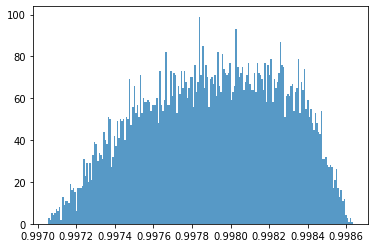

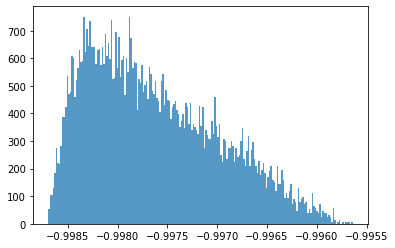

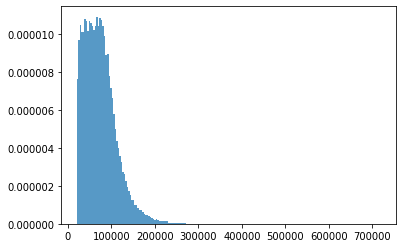

In [3]:
#pTB1 = Events.loc[df['category'] == 'pTB1']
#pTB2 = df.loc[df['category'] == 'pTB2']

plt.hist(Events[0], stacked=True, alpha=0.75, bins = 200)
plt.show()
plt.hist(Events[1], density=True, alpha=0.75, bins = 200)
plt.show()

dfEven = pd.read_csv('../dataset-and-plotting/CSV/VHbb_data_2jet_even.csv')
dfOdd = pd.read_csv('../dataset-and-plotting/CSV/VHbb_data_2jet_odd.csv')

df = pd.concat([dfEven,dfOdd])

real_events = df.loc[df['category'] == 'VH']['pTB2']

plt.hist(real_events, density=True, alpha=0.75, bins = 200)
plt.show()